## Natural Language Processing(NLP)- Text Classification

The goal is to build a Naïve Bayes classification model that is able to predict the class (category) of an unseen document correctly out of 91 classes

In [101]:
# Importing needed libraries
import os
import pandas as pd

# Cleaning and Normalization
import re
import numpy as np
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer


# Modelling and Evaluating
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_fscore_support
import pickle 




from nltk.tokenize import word_tokenize

## 1. Reading data

In [102]:
def read_folders_to_dataframe(parent_dir: str) -> pd.DataFrame:
    data = []
    # loop through each folder in the parent directory and its subdirectories
    for root, _, files in os.walk(parent_dir):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            try:
                with open(file_path, 'r', encoding='utf-8-sig') as f:
                    file_contents = f.read()
            except UnicodeDecodeError:
                with open(file_path, 'r', encoding='latin-1') as f:
                    file_contents = f.read()
            # append the folder name and file contents to the list
            data.append([os.path.basename(root), file_contents])
    # create a DataFrame from the list
    df = pd.DataFrame(data, columns=['folder_name', 'file_contents'])
    return df



In [103]:
data = read_folders_to_dataframe('./training')
print(data.head(10))


  folder_name                                      file_contents
0    training     Bud1  P      P           0          ...
1         tin  \n\nTHAI TIN EXPORTS FALL IN FEBRUARY\n\n    B...
2         tin  \n\nZAIRE ACCEPTS TIN-EXPORT QUOTA, ATPC SAYS\...
3         tin  \n\nECONOMIC SPOTLIGHT - BOLIVIA\n\n<AUTHOR>  ...
4         tin  \n\nTHAI TIN EXPORTS RISE IN JANUARY\n\n    BA...
5         tin  \n\nTIN PACT EXTENSION LIKELY - ITC DELEGATES\...
6         tin  \n\nU.S. DEFENDS STOCKPILED TIN SALES IN 1986\...
7         tin  \n\nBOLIVIAN TIN MINERS START HUNGER STRIKE\n\...
8         tin  \n\nMAJOR TIN CENTERS PARALYSED BOLIVIA UNION ...
9         tin  \n\n(RPT) U.S. SAYS TIN DISPOSALS WILL NOT AFF...


In [104]:
data = data.drop(index=0).reset_index(drop=True)
print(data.head(10))


  folder_name                                      file_contents
0         tin  \n\nTHAI TIN EXPORTS FALL IN FEBRUARY\n\n    B...
1         tin  \n\nZAIRE ACCEPTS TIN-EXPORT QUOTA, ATPC SAYS\...
2         tin  \n\nECONOMIC SPOTLIGHT - BOLIVIA\n\n<AUTHOR>  ...
3         tin  \n\nTHAI TIN EXPORTS RISE IN JANUARY\n\n    BA...
4         tin  \n\nTIN PACT EXTENSION LIKELY - ITC DELEGATES\...
5         tin  \n\nU.S. DEFENDS STOCKPILED TIN SALES IN 1986\...
6         tin  \n\nBOLIVIAN TIN MINERS START HUNGER STRIKE\n\...
7         tin  \n\nMAJOR TIN CENTERS PARALYSED BOLIVIA UNION ...
8         tin  \n\n(RPT) U.S. SAYS TIN DISPOSALS WILL NOT AFF...
9         tin  \n\nATPC MEMBERS FIND WAYS TO CURB TIN EXPORTS...


solve the issuse in index [0]

### Text Preprocessing

* It involves cleaning and transforming raw text data into a format that can be easily understood and analyzed by machine learning models 

## Cleaning Text

* Cleaning text involves several steps to prepare the text data for analysis or machine learning. 

In [105]:
## Removes all punctuation marks from a given text.

def remove_punctuations(text):
    return re.sub(r'[^\w\s]', '', text)



In [106]:
## Removes all stopwords from a given text.

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return " ".join(filtered_tokens)


In [107]:
## Removes all non-ASCII characters from a given text.

def remove_special_chars(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

In [108]:
## Removes all HTML tags and newlines from a given text.

def remove_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    clean_text = soup.get_text().replace("\n", " ").strip()
    return clean_text

In [109]:
## Cleans a given text by removing HTML tags, punctuation marks, stopwords, and non-ASCII characters.

def clean_text(text):
    text = remove_tags(text)
    text = remove_punctuations(text)
    text = remove_stopwords(text)
    text = remove_special_chars(text)
    return text

In [110]:
data["text"] = data["file_contents"].apply(clean_text)
data.head()

,folder_name,file_contents,text
0,tin,\n\nTHAI TIN EXPORTS FALL IN FEBRUARY\n\n B...,THAI TIN EXPORTS FALL IN FEBRUARY BANGKOK Marc...
1,tin,"\n\nZAIRE ACCEPTS TIN-EXPORT QUOTA, ATPC SAYS\...",ZAIRE ACCEPTS TINEXPORT QUOTA ATPC SAYS KUALA ...
2,tin,\n\nECONOMIC SPOTLIGHT - BOLIVIA\n\n<AUTHOR> ...,ECONOMIC SPOTLIGHT BOLIVIA By Paul Iredale Reu...
3,tin,\n\nTHAI TIN EXPORTS RISE IN JANUARY\n\n BA...,THAI TIN EXPORTS RISE IN JANUARY BANGKOK March...
4,tin,\n\nTIN PACT EXTENSION LIKELY - ITC DELEGATES\...,TIN PACT EXTENSION LIKELY ITC DELEGATES LONDON...


### Normalize Text

Normalizing text typically involves converting text to a standard form or representation. 


* Stemmer text : using PorterStemmer



* Lower case text

In [111]:
def stem_text(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(stemmed_tokens)

In [112]:
def standardize_text(text):
    return text.lower()


In [113]:
def normalize_text(text):
    text = stem_text(text)
    text = standardize_text(text)
    return text


In [114]:
data["text"] = data["text"].apply(normalize_text)
data.head()

,folder_name,file_contents,text
0,tin,\n\nTHAI TIN EXPORTS FALL IN FEBRUARY\n\n B...,thai tin export fall in februari bangkok march...
1,tin,"\n\nZAIRE ACCEPTS TIN-EXPORT QUOTA, ATPC SAYS\...",zair accept tinexport quota atpc say kuala lum...
2,tin,\n\nECONOMIC SPOTLIGHT - BOLIVIA\n\n<AUTHOR> ...,econom spotlight bolivia by paul iredal reuter...
3,tin,\n\nTHAI TIN EXPORTS RISE IN JANUARY\n\n BA...,thai tin export rise in januari bangkok march ...
4,tin,\n\nTIN PACT EXTENSION LIKELY - ITC DELEGATES\...,tin pact extens like itc deleg london march 24...


In this step I'll perform:

* Word tokenization: using NLTK.


### Word tokenization

In [115]:
# Word tokenization
data['tokens'] = data['text'].apply(lambda x: nltk.word_tokenize(x.lower()))
data.head()

,folder_name,file_contents,text,tokens
0,tin,\n\nTHAI TIN EXPORTS FALL IN FEBRUARY\n\n B...,thai tin export fall in februari bangkok march...,"[thai, tin, export, fall, in, februari, bangko..."
1,tin,"\n\nZAIRE ACCEPTS TIN-EXPORT QUOTA, ATPC SAYS\...",zair accept tinexport quota atpc say kuala lum...,"[zair, accept, tinexport, quota, atpc, say, ku..."
2,tin,\n\nECONOMIC SPOTLIGHT - BOLIVIA\n\n<AUTHOR> ...,econom spotlight bolivia by paul iredal reuter...,"[econom, spotlight, bolivia, by, paul, iredal,..."
3,tin,\n\nTHAI TIN EXPORTS RISE IN JANUARY\n\n BA...,thai tin export rise in januari bangkok march ...,"[thai, tin, export, rise, in, januari, bangkok..."
4,tin,\n\nTIN PACT EXTENSION LIKELY - ITC DELEGATES\...,tin pact extens like itc deleg london march 24...,"[tin, pact, extens, like, itc, deleg, london, ..."


### Vocabulary set extraction.

In [116]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

documents = data['text'].tolist() 

# Create a CountVectorizer to convert text data into a bag-of-words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)

# Get the vocabulary set
vocabulary_set = set(vectorizer.get_feature_names_out())


print("The first 10 words in the Vocabulary Set:", list(vocabulary_set)[:10])

print("Number of words in the Vocabulary Set:", len(vocabulary_set))

The first 10 words in the Vocabulary Set: ['025', 'foot', 'pfd', 'greatli', 'mclennan', '151500', '9201', 'azerbaijan', 'fison', '3217500']
Number of words in the Vocabulary Set: 33705


### Estimation of Model Parameters


* Estimate Prior Distribution:



This is the probability that a randomly selected document belongs to a specific class.

In [117]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, data[('folder_name')], test_size=0.15, random_state=42)

In [118]:
class_counts = y_train.value_counts()
prior_distribution = class_counts / len(y_train)

prior_distribution

earn        0.252448
unknown     0.161324
acq         0.145140
money-fx    0.046902
grain       0.037522
              ...   
sun-meal    0.000103
naphtha     0.000103
lin-oil     0.000103
rand        0.000103
nzdlr       0.000103
Name: folder_name, Length: 90, dtype: float64

* Estimate Likelihood:

In [119]:
# Add-1 Laplacian Smoothing for likelihood estimation
alpha = 1  

# Estimate likelihood of each word in the training dataset for each class
likelihoods = defaultdict(lambda: defaultdict(float))

# Convert sparse matrix to dense representation
X_train_dense = X_train.toarray()

for i in range(len(X_train_dense)):
    tokens = data['tokens'].iloc[i]
    label = y_train.iloc[i]

    class_counts[label] += len(tokens)

    for token in tokens:
        word_counts_per_class[token][label] += 1

# Print only the first 10 likelihood values for each word and class
for word in list(vocabulary_set)[:2]:
    for class_label in set(y_train):
        likelihood = (word_counts_per_class[word][class_label] + alpha) / (class_counts[class_label] + alpha * len(vocabulary_set))
        likelihoods[word][class_label] = likelihood
        print(f'Word: {word}, Class: {class_label}, Likelihood: {likelihood}')



Word: 025, Class: jobs, Likelihood: 2.591143471614023e-05
Word: 025, Class: castor-oil, Likelihood: 2.963928984261537e-05
Word: 025, Class: gnp, Likelihood: 9.234036659125537e-05
Word: 025, Class: dlr, Likelihood: 2.1378027663167795e-05
Word: 025, Class: palm-oil, Likelihood: 2.8290944068803576e-05
Word: 025, Class: jet, Likelihood: 2.9552574029197942e-05
Word: 025, Class: nat-gas, Likelihood: 2.555192150449714e-05
Word: 025, Class: copra-cake, Likelihood: 2.9567428520741552e-05
Word: 025, Class: veg-oil, Likelihood: 2.4093482712926154e-05
Word: 025, Class: palladium, Likelihood: 2.9243186337583345e-05
Word: 025, Class: retail, Likelihood: 2.8839221341023793e-05
Word: 025, Class: strategic-metal, Likelihood: 2.8221482192244737e-05
Word: 025, Class: nkr, Likelihood: 2.9607698001480386e-05
Word: 025, Class: sugar, Likelihood: 2.2039538932845525e-05
Word: 025, Class: palmkernel, Likelihood: 2.9575298710516975e-05
Word: 025, Class: money-fx, Likelihood: 1.2334866968459745e-05
Word: 025, Cl

### Exploaraity Data Analysis - EDA.

 this step include :
    
    
* Plot the distribution of classes using bar plot.
    
    
* Average Text Length using bar plot.
    
    
* Most Common words in each class and its frequency using Word Cloud.

### Plot the distribution of classes


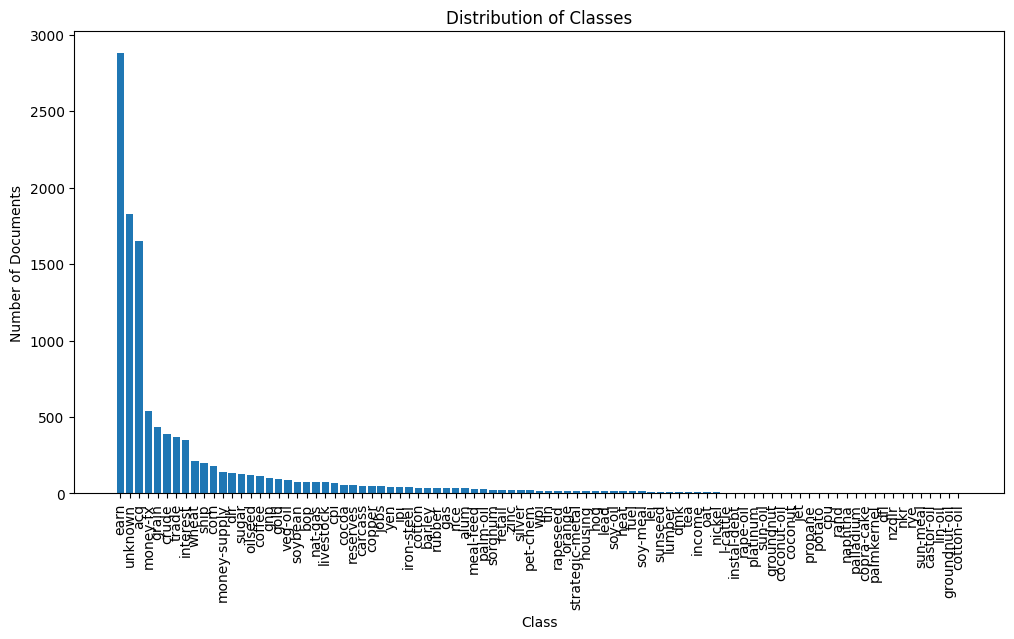

In [120]:
import matplotlib.pyplot as plt
# Count the number of documents in each class
class_counts = data['folder_name'].value_counts()

# Plot the distribution of classes
plt.figure(figsize=(12,6))
plt.bar(class_counts.index, class_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Documents')
plt.title('Distribution of Classes')
plt.show()

1- The distribution of classes is imbalanced. 



2- "earn" class include largest number of doc


### Average Text Length

In [121]:
def sort_dataframe_by_text_length(data):
    # Add a new column with the length of the 'text' column
    data['text_length'] = data['text'].str.len()

    # Sort the DataFrame based on the length of the 'text' column within each class
    df_sorted = data.sort_values(by=['folder_name', 'text_length'], ascending=[True, False])

    return df_sorted



In [122]:
data = sort_dataframe_by_text_length(data)
data


,folder_name,file_contents,text,tokens,text_length
9382,acq,\n\nTALKING POINT/BORG-WARNER CORP <BOR>\n\n<A...,talk pointborgwarn corp by patti domm reuter n...,"[talk, pointborgwarn, corp, by, patti, domm, r...",3248
10070,acq,\n\nPESCH SEES SHAREHOLDER SUPPORT IN AMI <AMI...,pesch see sharehold support in ami bid by patt...,"[pesch, see, sharehold, support, in, ami, bid,...",3050
10881,acq,\n\nECONOMIC SPOTLIGHT - JAPAN BUYING OVERSEAS...,econom spotlight japan buy oversea firm by jef...,"[econom, spotlight, japan, buy, oversea, firm,...",3003
9363,acq,\n\nTWA <TWA> TANGLES PIEDMONT <PIE> SITUATION...,twa tangl piedmont situat by patti domm reuter...,"[twa, tangl, piedmont, situat, by, patti, domm...",2933
10865,acq,\n\nTALKING POINT/VIACOM INTERNATIONAL <VIA>\n...,talk pointviacom intern by cal mankowski reute...,"[talk, pointviacom, intern, by, cal, mankowski...",2859
...,...,...,...,...,...
9118,zinc,\n\nPEGASUS GOLD <PGULF> STARTS MILLING IN MON...,pegasu gold start mill in montana jefferson ci...,"[pegasu, gold, start, mill, in, montana, jeffe...",443
9124,zinc,"\n\nHUDSON BAY MINING CUTS U.S., CANADA ZINC P...",hudson bay mine cut us canada zinc price toron...,"[hudson, bay, mine, cut, us, canada, zinc, pri...",435
9116,zinc,\n\nBALL <BLL> TO SUPPLY PENNY BLANKS TO MINTS...,ball to suppli penni blank to mint munci ind a...,"[ball, to, suppli, penni, blank, to, mint, mun...",393
9131,zinc,\n\nOECD EUROPE ZINC STOCKS RISE IN JANUARY\n\...,oecd europ zinc stock rise in januari london m...,"[oecd, europ, zinc, stock, rise, in, januari, ...",378


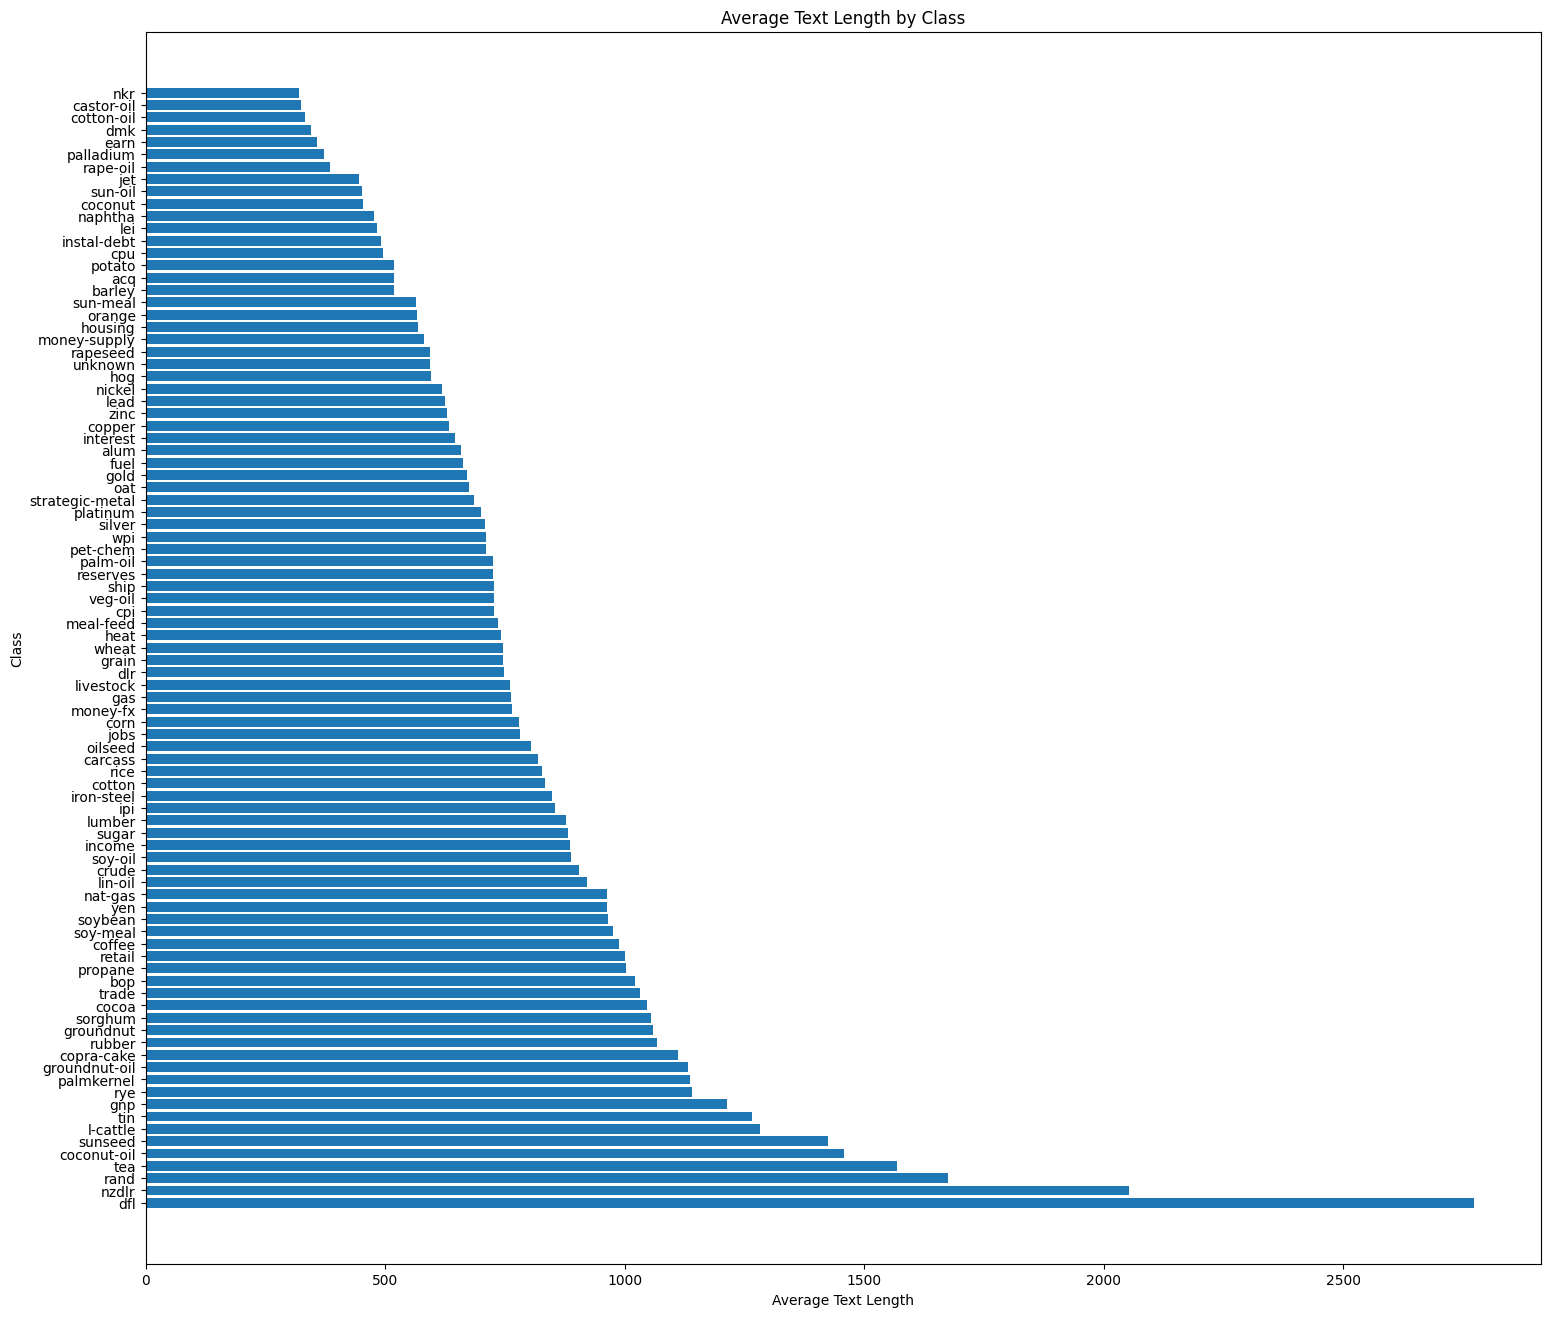

In [123]:
avg_text_length_by_class = data.groupby('folder_name')['text_length'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(18, 16))
ax.barh(avg_text_length_by_class.index, avg_text_length_by_class.values)
ax.set_xlabel('Average Text Length')
ax.set_ylabel('Class')
ax.set_title('Average Text Length by Class')
plt.show()

* The length of the text gives indication of its class.

### Average Frequency of numbers in each Class.

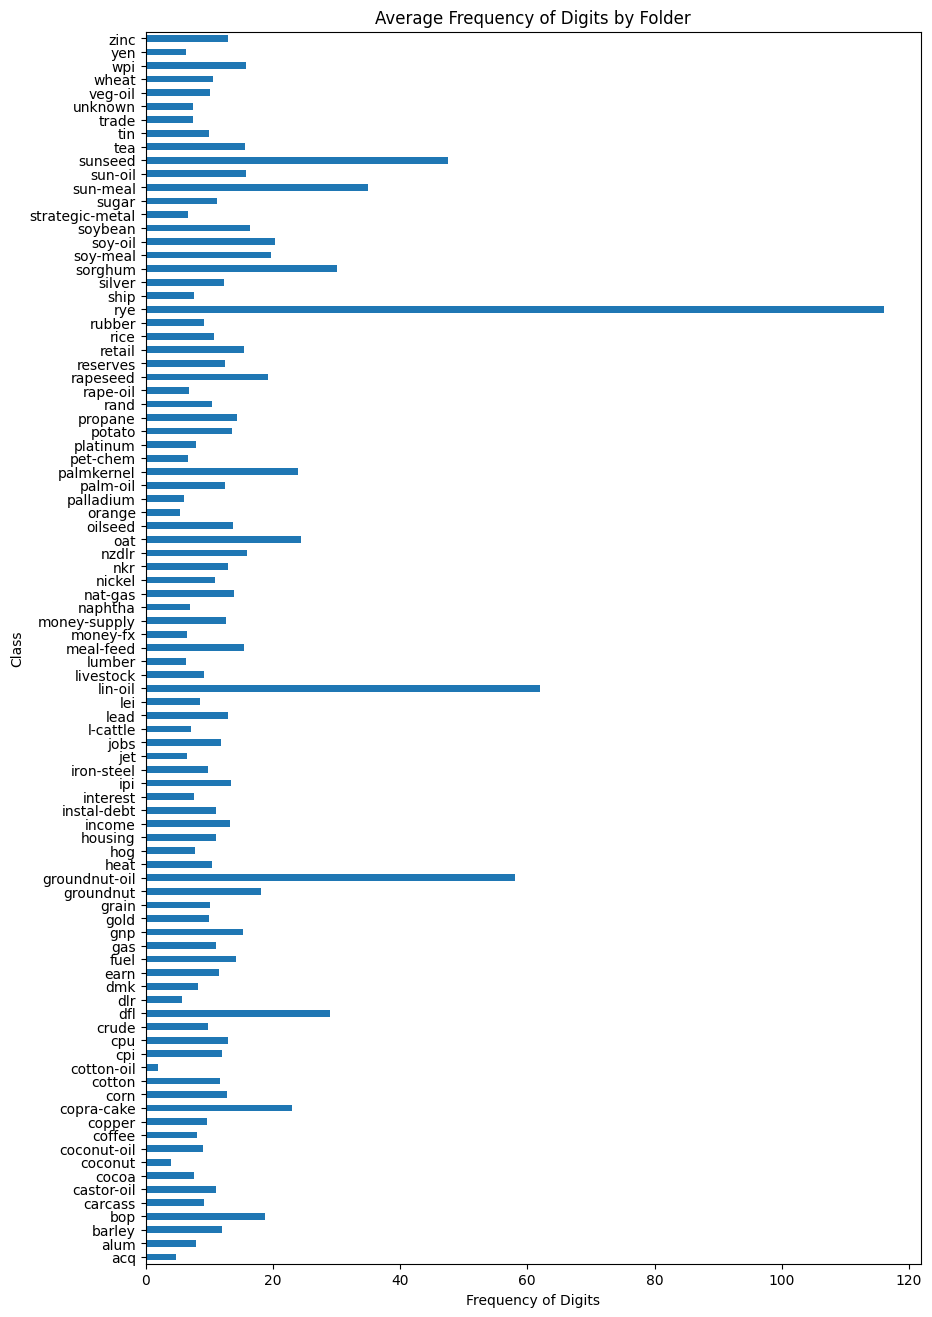

In [124]:
number_pattern = r'\d+(\.\d+)?'

def count_numbers(text):
    return len(re.findall(number_pattern, text))

# Group the data by folder_name and calculate the mean frequency of numbers for each group
freq_by_folder = data.groupby('folder_name')['text'].apply(lambda x: x.apply(count_numbers).mean())

# Plot the results in a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 16))
freq_by_folder.plot(kind='barh', ax=ax)
ax.set_title('Average Frequency of Digits by Folder')
ax.set_xlabel('Frequency of Digits')
ax.set_ylabel('Class')
plt.show()

The number of digits differ between classes.

### Features Generation and Selection

* Document Length.


* Frequency of digits in the document.


In [125]:
# Add document length as a feature
data['doc_length'] = data['text_length']

# Add frequency of digits as a feature
data['digit_freq'] = data['text'].apply(count_numbers) 

feature_cols = ['doc_length', 'digit_freq']


In [126]:
data.columns

Index(['folder_name', 'file_contents', 'text', 'tokens', 'text_length',
       'doc_length', 'digit_freq'],
      dtype='object')

In [127]:
data = data.rename(columns={'folder_name': 'Class'})
data.drop(columns=["file_contents", "tokens"], inplace=True)
data.columns

Index(['Class', 'text', 'text_length', 'doc_length', 'digit_freq'], dtype='object')

In [128]:
data.head()

,Class,text,text_length,doc_length,digit_freq
9382,acq,talk pointborgwarn corp by patti domm reuter n...,3248,3248,25
10070,acq,pesch see sharehold support in ami bid by patt...,3050,3050,13
10881,acq,econom spotlight japan buy oversea firm by jef...,3003,3003,4
9363,acq,twa tangl piedmont situat by patti domm reuter...,2933,2933,16
10865,acq,talk pointviacom intern by cal mankowski reute...,2859,2859,33


In [129]:
data.drop(columns=["doc_length"], inplace=True)
data.head()

,Class,text,text_length,digit_freq
9382,acq,talk pointborgwarn corp by patti domm reuter n...,3248,25
10070,acq,pesch see sharehold support in ami bid by patt...,3050,13
10881,acq,econom spotlight japan buy oversea firm by jef...,3003,4
9363,acq,twa tangl piedmont situat by patti domm reuter...,2933,16
10865,acq,talk pointviacom intern by cal mankowski reute...,2859,33


### Machine Learning Algorithms



I have used two machine learning algorithms, which are:  Naïve Bayes and Random Forest

### Training Models



In this step I'll train models on 85% of the data and test on the remaining 15%. 
The models I'll train on are:



In [130]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, data['Class'], test_size=0.15, random_state=42)

### Train Naive Bayes

In [131]:
# Train a Multinomial Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)


MultinomialNB()

In [132]:
# Make predictions on the train set
nb_pred = nb_model.predict(X_train)
print(classification_report(y_train, nb_pred, zero_division=1))

                 precision    recall  f1-score   support

            acq       0.47      0.86      0.61      1402
           alum       0.29      0.07      0.11        28
         barley       1.00      0.00      0.00        28
            bop       1.00      0.31      0.47        61
        carcass       1.00      0.05      0.09        43
     castor-oil       1.00      0.00      0.00         1
          cocoa       1.00      0.02      0.04        49
        coconut       1.00      0.00      0.00         2
    coconut-oil       1.00      0.00      0.00         4
         coffee       1.00      0.00      0.00        94
         copper       1.00      0.00      0.00        44
     copra-cake       1.00      0.00      0.00         1
           corn       1.00      0.00      0.00       157
         cotton       1.00      0.00      0.00        33
     cotton-oil       1.00      0.00      0.00         1
            cpi       1.00      0.00      0.00        58
            cpu       1.00    

### Evaluate Naive Bayes

In [133]:
# Make predictions on the test set
nb_pred = nb_model.predict(X_test)
print(classification_report(y_test, nb_pred, zero_division=1))

                 precision    recall  f1-score   support

            acq       0.43      0.81      0.56       248
           alum       0.00      0.00      0.00         7
         barley       1.00      0.00      0.00         9
            bop       1.00      0.07      0.13        14
        carcass       1.00      0.00      0.00         7
          cocoa       1.00      0.00      0.00         6
        coconut       1.00      0.00      0.00         2
         coffee       1.00      0.00      0.00        17
         copper       1.00      0.00      0.00         3
     copra-cake       1.00      0.00      0.00         1
           corn       1.00      0.00      0.00        24
         cotton       1.00      0.00      0.00         6
            cpi       1.00      0.00      0.00        11
          crude       0.20      0.20      0.20        64
            dfl       1.00      0.00      0.00         1
            dlr       1.00      0.00      0.00        10
           earn       0.60    

### Train Random Forest

Hyperparameters:

* n_estimators = 100: the number of trees in the forest
* max_depth = 50: the maximum depth of the trees
* random_state = 42: for reproducibility of results

In [134]:
# Train a Random Forest model on 85% of the data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Evaluate Random Forest

In [135]:
# Make predictions on the test set
rf_pred = rf_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, rf_pred, zero_division=1))

                 precision    recall  f1-score   support

            acq       0.45      0.67      0.54       248
           alum       0.00      0.00      0.00         7
         barley       0.00      0.00      0.00         9
            bop       0.33      0.14      0.20        14
        carcass       0.00      0.00      0.00         7
          cocoa       0.00      0.00      0.00         6
        coconut       1.00      0.00      0.00         2
         coffee       1.00      0.00      0.00        17
         copper       0.00      0.00      0.00         3
     copra-cake       1.00      0.00      0.00         1
           corn       0.00      0.00      0.00        24
         cotton       1.00      0.00      0.00         6
            cpi       1.00      0.00      0.00        11
          crude       0.50      0.02      0.03        64
            dfl       1.00      0.00      0.00         1
            dlr       0.00      0.00      0.00        10
           earn       0.52    

## Model Evaluation

## Compare Results of the Two models

In [136]:
# Compute accuracy for each model
rf_acc = accuracy_score(y_test, rf_pred)
nb_acc = accuracy_score(y_test, nb_pred)


# Compute precision, recall, and F1-score for each model
rf_p, rf_r, rf_f1, _ = precision_recall_fscore_support(y_test, rf_pred, average='weighted', zero_division=1)
nb_p, nb_r, nb_f1, _ = precision_recall_fscore_support(y_test, nb_pred, average='weighted', zero_division=1)


# Print the results
print("Random Forest: Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F1-score = {:.3f}".format(rf_acc, rf_p, rf_r, rf_f1))
print("Naive Bayes: Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F1-score = {:.3f}".format(nb_acc, nb_p, nb_r, nb_f1))

# Compute evaluation metrics for each model
rf_metrics = [rf_acc, rf_p, rf_r, rf_f1]
nb_metrics = [nb_acc, nb_p, nb_r, nb_f1]


Random Forest: Accuracy = 0.455, Precision = 0.433, Recall = 0.455, F1-score = 0.394
Naive Bayes: Accuracy = 0.500, Precision = 0.608, Recall = 0.500, F1-score = 0.439


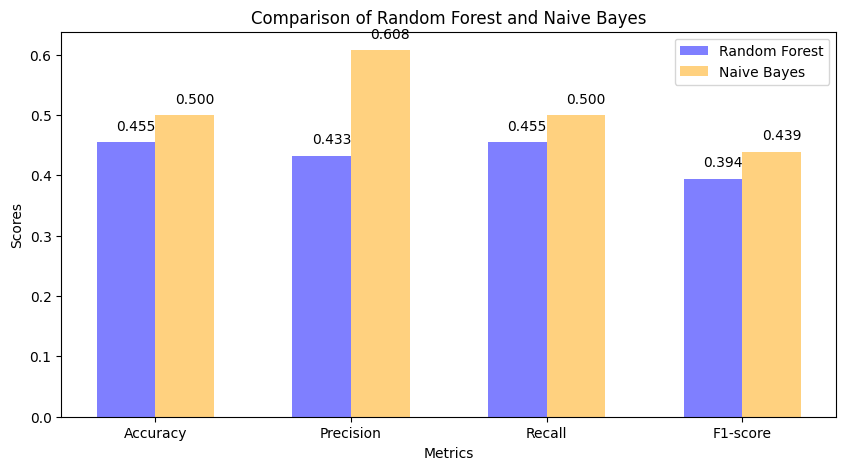

In [137]:
# Define the data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Set the positions and width of the bars
pos = list(range(len(metrics)))
width = 0.3

# Create the figure and set the plot dimensions
fig, ax = plt.subplots(figsize=(10, 5))

# Create the bars for each model (Random Forest and Naive Bayes)
plt.bar([p - width/2 for p in pos], rf_metrics, width, alpha=0.5, color='blue', label='Random Forest')
plt.bar([p + width/2 for p in pos], nb_metrics, width, alpha=0.5, color='orange', label='Naive Bayes')

# Set the plot title, labels, and legend
ax.set_title('Comparison of Random Forest and Naive Bayes')
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_xticks(pos)
ax.set_xticklabels(metrics)
plt.legend(loc='upper right')

# Add text labels to each bar
for i, val in enumerate(rf_metrics):
    ax.text(i - width/2 - 0.05, val + 0.02, "{:.3f}".format(val))
for i, val in enumerate(nb_metrics):
    ax.text(i + width/2 - 0.05, val + 0.02, "{:.3f}".format(val))

# Display the plot
plt.show()


Here are some observations and conclusions:

**Accuracy** :
Naive Bayes has a slightly higher accuracy compared to Random Forest.


**Precision** :
Naive Bayes has significantly higher precision than Random Forest. This indicates that when Naive Bayes predicts a positive class, it is more likely to be correct compared to Random Forest.



**Recall**:
Random Forest and Naive Bayes have similar recall values. Recall measures the ability of a model to capture all the relevant instances of a class.


**F1-score**:
Naive Bayes has a higher F1-score compared to Random Forest. The F1-score is the harmonic mean of precision and recall and provides a balanced measure of a model's performance.


**Naive Bayes performs better in terms of precision and F1-score, while Random Forest and Naive Bayes have similar recall values.**